In [41]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir

%matplotlib inline

In [72]:
folder = 'Matrices/'

In [79]:
list_files = [f for f in listdir(folder) if f.endswith('.txt') and 'Cloud' in f]
list_files.sort()

In [80]:
n = len(list_files)

In [81]:
Clouds = np.zeros((n,40000))

In [82]:
for i in range(len(list_files)):
    Clouds[i,:] = np.loadtxt(folder+list_files[i]).reshape(-1) 

In [83]:
dat = Clouds/Clouds.max()
df = pd.DataFrame(data=dat, dtype='float64')

In [84]:
df['Temperature'] = np.loadtxt(folder+'Temperature.txt')

In [85]:
df['Double structure'] = np.loadtxt(folder+'Target.txt')

In [88]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39992,39993,39994,39995,39996,39997,39998,39999,Temperature,Double structure
0,0.004396,0.012269,0.004943,0.000786,-0.001864,0.000523,-0.005252,0.002382,0.015224,0.012951,...,0.002421,0.004104,0.007309,0.003412,0.006510,0.012275,0.007050,0.005660,0.56,1.0
1,-0.004437,-0.004618,-0.008598,-0.004259,-0.002238,0.016654,0.001298,-0.002149,-0.002342,-0.005851,...,0.002657,0.002531,0.008558,-0.001768,0.003378,-0.000757,0.000040,0.006988,0.34,1.0
2,-0.001947,-0.007481,-0.007840,-0.000182,-0.010254,-0.007295,0.006740,-0.003416,0.004072,0.012002,...,0.005986,-0.014152,-0.001443,-0.008277,0.004841,0.007783,-0.009985,0.000333,0.77,0.0
3,0.012083,0.002458,0.000565,-0.003540,0.005139,0.010817,-0.004909,-0.004675,0.000277,0.004512,...,-0.010388,0.000943,0.000221,0.002509,-0.006623,0.000955,0.000163,-0.006895,0.14,1.0
4,-0.001120,-0.008992,0.002132,-0.013249,0.000347,0.004930,-0.001163,0.007965,0.014791,-0.002760,...,0.005756,0.005446,0.002103,-0.002098,-0.003315,0.005372,0.003083,0.005376,0.39,1.0


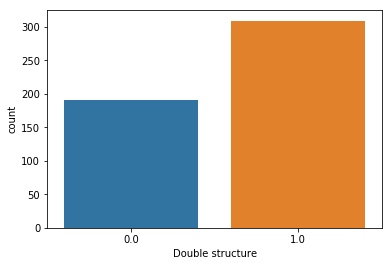

In [89]:
sns.countplot(x='Double structure', data=df)

In [110]:
df[['Temperature', 'Double structure']].corr()

,Temperature,Double structure
Temperature,1.000000,-0.833067
Double structure,-0.833067,1.000000


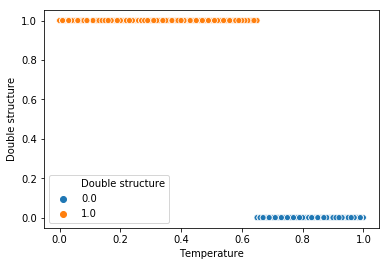

In [111]:
sns.scatterplot(x='Temperature', y='Double structure', data=df, hue='Double structure')

# Train and test data split

In [112]:
from sklearn.model_selection import train_test_split

In [124]:
X = df.drop('Double structure', axis=1)
y = df['Double structure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [125]:
dat2 = pd.concat((X_train,y_train), axis=1)
len(dat2)

350

In [126]:
dat_train = dat2[(dat2['Temperature']<0.58) | (dat2['Temperature']>0.75)]
len(dat_train)

288

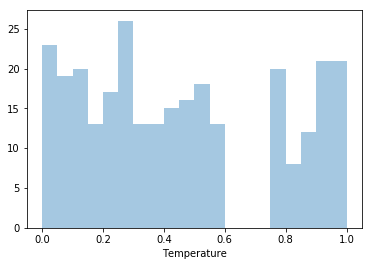

In [127]:
sns.distplot(dat_train['Temperature'],bins=20,kde=False)

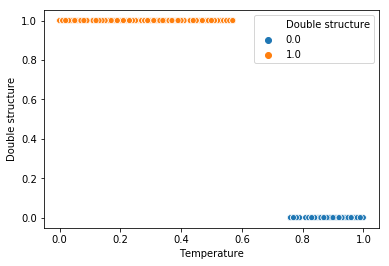

In [128]:
sns.scatterplot(x='Temperature', y='Double structure', data=dat_train, hue='Double structure')

In [129]:
X_train = dat_train.drop(['Temperature','Double structure'],axis=1)
y_train = dat_train['Double structure']

# Model selection

**Random forest**

In [130]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [131]:
forest = RandomForestClassifier(n_estimators=300)

In [132]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
predictions_forest = forest.predict(X_test.drop('Temperature', axis=1))

In [134]:
print (confusion_matrix(y_test, predictions_forest))
print('\n')
print (classification_report(y_test, predictions_forest))

[[66  0]
 [10 74]]


              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        66
         1.0       1.00      0.88      0.94        84

    accuracy                           0.93       150
   macro avg       0.93      0.94      0.93       150
weighted avg       0.94      0.93      0.93       150



**Support vector classification**

In [135]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [136]:
svc = SVC()

In [137]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [138]:
predictions_svc = svc.predict(X_test.drop('Temperature', axis=1))

In [139]:
print (confusion_matrix(y_test, predictions_svc))
print('\n')
print (classification_report(y_test, predictions_svc))

[[66  0]
 [ 9 75]]


              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94        66
         1.0       1.00      0.89      0.94        84

    accuracy                           0.94       150
   macro avg       0.94      0.95      0.94       150
weighted avg       0.95      0.94      0.94       150



**Optimize the parameters**

In [140]:
param_grid1 = dict(C=[0.1,0.5,1,5,10,100],gamma = [10,5,2,1,1e-1,1e-2,1e-3])
grid = GridSearchCV(SVC(),param_grid=param_grid1)

In [141]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100],
                         'gamma': [10, 5, 2, 1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [147]:
predictions_grid = grid.predict(X_test.drop('Temperature', axis=1))

In [148]:
grid.best_params_

{'C': 0.1, 'gamma': 0.1}

In [149]:
print (confusion_matrix(y_test, predictions_grid))
print('\n')
print (classification_report(y_test, predictions_grid))

[[50  0]
 [ 5 70]]


              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        50
         1.0       1.00      0.93      0.97        75

    accuracy                           0.96       125
   macro avg       0.95      0.97      0.96       125
weighted avg       0.96      0.96      0.96       125



In [150]:
dat_f = pd.DataFrame(X_test['Temperature'])

In [151]:
dat_f['True value'] = y_test
dat_f['Pred value'] = predictions_grid+0.1

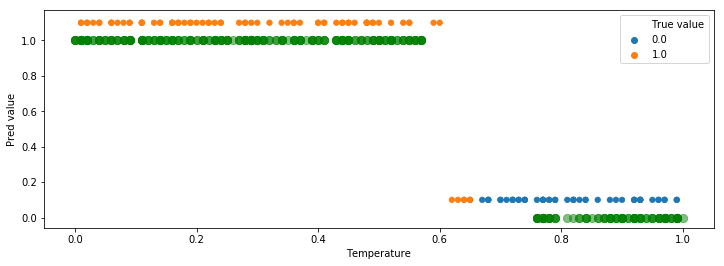

In [152]:
plt.figure(figsize=(12,4))
sns.scatterplot(x='Temperature', y='Double structure',data=dat_train,color='g',alpha=0.5,edgecolor='g',s=70)
sns.scatterplot(x='Temperature', y='Pred value', data=dat_f, hue='True value', edgecolor=None, s=30)
plt.savefig('Figure_Output.pdf')
plt.legend()

In [153]:
training_set = pd.concat((X_train, y_train), axis=1)

In [154]:
len(dat_train)

288

# Start over and use temperature column to train

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 40002 entries, 0 to Double structure
dtypes: float64(40002)
memory usage: 152.6 MB


In [170]:
X = df.drop('Double structure', axis=1)
y = df['Double structure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [171]:
trainSet = pd.concat((X_train,y_train), axis=1)

In [172]:
trainSet = trainSet[(trainSet['Temperature']<0.58) | (trainSet['Temperature']>0.75)]

In [173]:
X_train = trainSet.drop('Double structure', axis = 1)
y_train = trainSet['Double structure']

# Model selection

**Random forest**

In [180]:
forest2 = RandomForestClassifier(n_estimators=300)

In [181]:
forest2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [182]:
predictions_forest2 = forest2.predict(X_test)

In [183]:
print (confusion_matrix(y_test, predictions_forest2))
print('\n')
print (classification_report(y_test, predictions_forest2))

[[33  0]
 [ 4 63]]


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        33
         1.0       1.00      0.94      0.97        67

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



**Support vector classification**

In [187]:
svc2 = SVC()

In [188]:
svc2.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [189]:
predictions_svc2 = svc2.predict(X_test)

In [190]:
print (confusion_matrix(y_test, predictions_svc2))
print('\n')
print (classification_report(y_test, predictions_svc2))

[[33  0]
 [ 4 63]]


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        33
         1.0       1.00      0.94      0.97        67

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



**Optimize the parameters SVC**

In [192]:
param_grid1 = dict(C=[0.1,0.5,1,5,10,100],gamma = [10,5,2,1,1e-1,1e-2,1e-3])
grid2 = GridSearchCV(SVC(),param_grid=param_grid1)

In [193]:
grid2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100],
                         'gamma': [10, 5, 2, 1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [194]:
predictions_grid2 = grid2.predict(X_test)

In [195]:
grid2.best_params_

{'C': 0.1, 'gamma': 0.1}

In [199]:
print (confusion_matrix(y_test, predictions_grid2))
print('\n')
print (classification_report(y_test, predictions_grid2))

[[33  0]
 [ 4 63]]


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        33
         1.0       1.00      0.94      0.97        67

    accuracy                           0.96       100
   macro avg       0.95      0.97      0.96       100
weighted avg       0.96      0.96      0.96       100



In [200]:
predDF = pd.DataFrame(X_test['Temperature'])
predDF['True value'] = y_test
predDF['Pred value'] = predictions_grid2+0.1

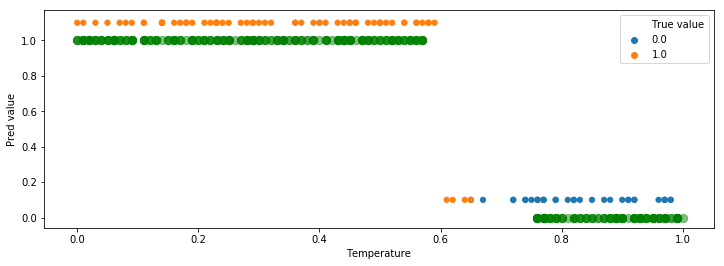

In [201]:
plt.figure(figsize=(12,4))
sns.scatterplot(x='Temperature', y='Double structure',data=trainSet,color='g',alpha=0.5,edgecolor='g',s=70)
sns.scatterplot(x='Temperature', y='Pred value', data=predDF, hue='True value', edgecolor=None, s=30)
plt.savefig('Figure_Output2.pdf')
plt.legend()